In [183]:
# metrics.py

In [184]:
import os
import json
import pandas as pd
import unicodedata
from math import radians, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt

In [185]:
# Process JSON files into dataframe
multiple_views_dir = 'multiple_views'
results = []

# Look for result.json files in multiple_views folder
for root, dirs, files in os.walk(multiple_views_dir):
    for file in files:
        if file == 'result.json':
            file_path = os.path.join(root, file)

            # Load JSON file
            with open(file_path, 'r') as f:
                data = json.load(f)

            # Flatten structure for dataframe
            result = {
                "standpoint_id": data.get("standpoint_id"),
                "gt_coords": data["ground_truth"].get("coords"),
                "gt_continent": data["ground_truth"].get("continent"),
                "gt_country": data["ground_truth"].get("country"),
                "gt_city": data["ground_truth"].get("city"),
                "gt_street": data["ground_truth"].get("street"),
                "gpt_continent": data["gpt_output"]["location"].get("continent"),
                "gpt_country": data["gpt_output"]["location"].get("country"),
                "gpt_city": data["gpt_output"]["location"].get("city"),
                "gpt_street": data["gpt_output"]["location"].get("street"),
                "gpt_reasoning": data["gpt_output"].get("reasoning"),
                "gpt_coords_lat": data["gpt_output"]["coords"].get("lattitude"),
                "gpt_coords_lon": data["gpt_output"]["coords"].get("longitude"),
                "num_adjacent_standpoints": data.get("num_adjacent_standpoints")
            }

            results.append(result)

results_df = pd.DataFrame(results)

In [ ]:
# Process text -- remove accents from strings
# Source: https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string
def normalize_text(text):
    return ''.join(
        c for c in unicodedata.normalize('NFKD', text)
        if not unicodedata.combining(c)
    )

In [187]:
# Process continent/country/city/street
results_df["gt_continent_norm"] = results_df["gt_continent"].apply(normalize_text)
results_df["gpt_continent_norm"] = results_df["gpt_continent"].apply(normalize_text)

results_df["gt_country_norm"] = results_df["gt_country"].apply(normalize_text)
results_df["gpt_country_norm"] = results_df["gpt_country"].apply(normalize_text)

results_df["gt_city_norm"] = results_df["gt_city"].apply(normalize_text)
results_df["gpt_city_norm"] = results_df["gpt_city"].apply(normalize_text)

results_df["gt_street_norm"] = results_df["gt_street"].apply(normalize_text)
results_df["gpt_street_norm"] = results_df["gpt_street"].apply(normalize_text)

# Check if ground truth and GPT values match
results_df["continent_match"] = (results_df["gt_continent_norm"] == results_df["gpt_continent_norm"])
results_df["country_match"] = (results_df["gt_country_norm"] == results_df["gpt_country_norm"])
results_df["city_match"] = (results_df["gt_city_norm"] == results_df["gpt_city_norm"])
results_df["street_match"] = (results_df["gt_street_norm"] == results_df["gpt_street_norm"])

In [188]:
# Haversine Distance: Gives the shortest distance path between the two points on the surface of the sphere (returns in km)
# Source: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# wrapper function for error handling and float conversion
def get_haversine_distance(row):
    if row['gpt_coords_lat'] == '' or row['gpt_coords_lon'] == '':
        return None
    
    return haversine_distance(
        float(row['gt_coords_lat']),
        float(row['gt_coords_lon']),
        float(row['gpt_coords_lat']),
        float(row['gpt_coords_lon'])
    )

In [189]:
# Process ground truth coords
results_df["gt_coords_lat"] = results_df["gt_coords"].apply(lambda x: float(x.split(",")[0]))
results_df["gt_coords_lon"] = results_df["gt_coords"].apply(lambda x: float(x.split(",")[1]))
results_df["gt_gpt_coords_haversine_dist"] = results_df.apply(get_haversine_distance, axis=1)

In [190]:
# Save results to CSV
results_df.to_csv("results.csv", index=False)
results_df.head(30)

,standpoint_id,gt_coords,gt_continent,gt_country,gt_city,gt_street,gpt_continent,gpt_country,gpt_city,gpt_street,...,gpt_city_norm,gt_street_norm,gpt_street_norm,continent_match,country_match,city_match,street_match,gt_coords_lat,gt_coords_lon,gt_gpt_coords_haversine_dist
0,135,"23.750585, 90.388233",Asia,Bangladesh,Dhaka,Bir Uttam Kazi Nuruzzaman Road,Asia,Bangladesh,Dhaka,Farmgate Area,...,Dhaka,Bir Uttam Kazi Nuruzzaman Road,Farmgate Area,True,True,True,False,23.750585,90.388233,0.537205
1,61,"39.903572, 116.395889",Asia,China,Beijing,Guangchang West Side Road,Asia,China,Beijing,National Museum of China,...,Beijing,Guangchang West Side Road,National Museum of China,True,True,True,False,39.903572,116.395889,0.414527
2,95,"30.045083, 31.24405",Africa,Egypt,Cairo,Mohammed Farid,North America,Mexico,Mexico City,Metro Station (likely a major hub like Bellas ...,...,Mexico City,Mohammed Farid,Metro Station (likely a major hub like Bellas ...,False,False,False,False,30.045083,31.244050,12369.154627
3,132,"23.743157, 90.391069",Asia,Bangladesh,Dhaka,Free School Street,Asia,Bangladesh,Dhaka,Residential Area,...,Dhaka,Free School Street,Residential Area,True,True,True,False,23.743157,90.391069,7.777935
4,59,"41.402678, 2.181271",Europe,Spain,Barcelona,Carrer del Consell de Cent,Europe,Spain,Barcelona,Carrer de Provença,...,Barcelona,Carrer del Consell de Cent,Carrer de Provenca,True,True,True,False,41.402678,2.181271,1.676265
5,92,"30.029674, 31.258262",Africa,Egypt,Cairo,Salah El-Deen,Africa,Egypt,Cairo,Salah Salem Street,...,Cairo,Salah El-Deen,Salah Salem Street,True,True,True,False,30.029674,31.258262,0.884908
6,66,"39.910488, 116.416315",Asia,China,Beijing,Dong Dan San Tiao,Asia,China,Beijing,near the Forbidden City,...,Beijing,Dong Dan San Tiao,near the Forbidden City,True,True,True,False,39.910488,116.416315,1.033004
7,104,"22.335455, 91.824697",Asia,Bangladesh,Chittagong,Folmondi Road,Asia,Bangladesh,Chattogram,Chittagong market area,...,Chattogram,Folmondi Road,Chittagong market area,True,True,False,False,22.335455,91.824697,4.888744
8,50,"13.775973, 100.480203",Asia,Thailand,Bangkok,Atsawin 2 Alley,Asia,Thailand,Bangkok,Ratchadaphisek Road,...,Bangkok,Atsawin 2 Alley,Ratchadaphisek Road,True,True,True,False,13.775973,100.480203,6.765058
9,68,"39.912866, 116.398192",Asia,China,Beijing,Gu Gong Dong Men Wai,Asia,China,Beijing,Forbidden City,...,Beijing,Gu Gong Dong Men Wai,Forbidden City,True,True,True,False,39.912866,116.398192,0.391104


In [ ]:
# Calculate basic metrics
total = len(results_df)

# Individual metrics
pct_continent = results_df["continent_match"].mean()
pct_country = results_df["country_match"].mean()
pct_city = results_df["city_match"].mean()
pct_street = results_df["street_match"].mean()

# All wrong 
pct_all_wrong = (~results_df["continent_match"] & ~results_df["country_match"] & ~results_df["city_match"] & ~results_df["street_match"]).mean()

# Continent correct (and country and city wrong)
pct_only_continent_correct = (results_df["continent_match"] & ~results_df["country_match"] & ~ results_df["city_match"] & ~results_df["street_match"]).mean()

# Only continent and country correct (and city wrong)
pct_only_continent_country_correct = (results_df["continent_match"] & results_df["country_match"] & ~results_df["city_match"] & ~results_df["street_match"]).mean()

# Coninenent, country, and city correct
pct_only_continent_country_city_correct = (results_df["continent_match"] & results_df["country_match"] & results_df["city_match"] & ~results_df["street_match"]).mean()

# All correct
pct_all_correct = ((results_df["continent_match"] & results_df["country_match"] & results_df["city_match"] & results_df["street_match"]).mean())

# Continent + country correct but city wrong
pct_continent_country_not_city = ((results_df["continent_match"] & results_df["country_match"] & ~results_df["city_match"]).mean())


In [192]:
# Overview Statistics
print(f"% Continent correct: {pct_continent:.2%}")
print(f"% Country correct: {pct_country:.2%}")
print(f"% City correct: {pct_city:.2%}")
print(f"% Street correct: {pct_street:.2%}")
print(f"% All wrong: {pct_all_wrong:.2%}")
print(f"% Only continent correct: {pct_only_continent_correct:.2%}")
print(f"% Only continent and country correct: {pct_only_continent_country_correct:.2%}")
print(f"% Only continent, country, and city correct: {pct_only_continent_country_city_correct:.2%}")
print(f"% All correct: {pct_all_correct:.2%}")
print(f"Total number of results: {total}")

% Continent correct: 95.05%
% Country correct: 85.71%
% City correct: 75.82%
% Street correct: 2.75%
% All wrong: 4.40%
% Only continent correct: 6.59%
% Only continent and country correct: 13.19%
% Only continent, country, and city correct: 69.23%
% All correct: 2.75%
Total number of results: 182


In [194]:
# Commonly missed countries
countries_wrong = results_df[~results_df["country_match"]][['standpoint_id', 'gt_country', 'gpt_country', 'gpt_reasoning', 'continent_match', 'city_match', 'gt_gpt_coords_haversine_dist']]
countries_wrong.head(50)

,standpoint_id,gt_country,gpt_country,gpt_reasoning,continent_match,city_match,gt_gpt_coords_haversine_dist
2,95,Egypt,Mexico,1. The images depict a subway station with dis...,False,False,12369.154627
16,32,Iraq,Iran,1. **Initial Standpoint:**\n - The architect...,True,False,698.149512
20,102,Bangladesh,Tanzania,1. **Initial Viewpoint Analysis**:\n - The s...,False,False,6571.930752
32,34,Iraq,Saudi Arabia,"1. The signage in the images is in Arabic, ind...",True,False,982.074985
47,11,Ethiopia,Kenya,1. **North View**: Shows a large overpass and ...,True,False,1165.202915
49,7,Ivory Coast,Côte d'Ivoire,"1. The environment is tropical, with lush gree...",True,True,2.616681
65,6,Ivory Coast,Cameroon,"1. The north view shows a sign for ""Hyper U,"" ...",True,False,1729.589104
70,1,Ivory Coast,Côte d'Ivoire,1. **Language and Signage**: The images have t...,True,True,0.820562
71,10,Ivory Coast,Côte d'Ivoire,1. The north view shows a road with cars drivi...,True,True,2.027527
77,21,Egypt,Greece,"1. The images show a large ship dry dock, indi...",False,False,944.082039


In [214]:
# Top wrong countries
countries_wrong['gt_country'].value_counts().reset_index(name='count')

,gt_country,count
0,Ivory Coast,8
1,Iraq,6
2,Egypt,4
3,Tanzania,3
4,Bangladesh,2
5,Ethiopia,2
6,India,1


In [ ]:
# Top wrong countries (and what GPT guessed)
wrong_grouped = countries_wrong.groupby(['gt_country', 'gpt_country']).size().reset_index(name='count')
wrong_grouped = wrong_grouped.sort_values('count', ascending=False)
wrong_grouped.head(20)

,gt_country,gpt_country,count
14,Ivory Coast,Côte d'Ivoire,6
17,Tanzania,Kenya,2
6,Ethiopia,Kenya,2
11,Iraq,Saudi Arabia,2
10,Iraq,Kuwait,1
16,Tanzania,Country,1
15,Ivory Coast,Kenya,1
13,Ivory Coast,Cameroon,1
12,Iraq,Turkey,1
0,Bangladesh,Malaysia,1


In [197]:
# Commonly missed cities (where country is correct)
cities_wrong = results_df[~results_df["city_match"] & results_df['country_match']][['standpoint_id', 'gt_city', 'gpt_city', 'gpt_reasoning', 'continent_match', 'country_match', 'gt_gpt_coords_haversine_dist']]
cities_wrong.head(50)

,standpoint_id,gt_city,gpt_city,gpt_reasoning,continent_match,country_match,gt_gpt_coords_haversine_dist
7,104,Chittagong,Chattogram,1. **Language and Scripts**: The signs in the ...,True,True,4.888744
10,103,Chittagong,Dhaka,1. **Language and Signage**: The signs and pos...,True,True,212.687431
12,168,Hong Kong,Kwun Tong District,1. **Language and Signage**: The use of Chines...,True,True,3.838319
19,161,Hong Kong,Kowloon,1. The images show a high-density urban area w...,True,True,8.061514
27,67,Beijing,Shenyang,1. The north and south views show traditional ...,True,True,628.434312
36,167,Hong Kong,Kowloon,1. **Architecture and Signage**: The presence ...,True,True,2.675762
52,129,Delhi,New Delhi,1. **Language and Road Signs**: The signs are ...,True,True,0.577487
59,118,Dar es Salaam,Zanzibar City,1. The architectural style seen in the images ...,True,True,73.724354
61,127,Delhi,New Delhi,1. **Road and Traffic Analysis**: The images s...,True,True,2.640543
80,121,Delhi,New Delhi,1. **Language and Signs:** The signs are in Hi...,True,True,7.944749


In [ ]:
# Top wrong cities (and what GPT guessed)
cities_wrong_grouped = cities_wrong.groupby(['gt_city', 'gpt_city']).size().reset_index(name='count')
cities_wrong_grouped = cities_wrong_grouped.sort_values('count', ascending=False)
cities_wrong_grouped.head(20)

,gt_city,gpt_city,count
5,Delhi,New Delhi,9
3,Chittagong,Dhaka,4
7,Hong Kong,Kowloon,4
0,Beijing,Shenyang,1
1,Beijing,Xi'an,1
2,Chittagong,Chattogram,1
4,Dar es Salaam,Zanzibar City,1
6,Guadalajara,Mexico City,1
8,Hong Kong,Kwun Tong District,1
9,Hong Kong,Victoria Harbour,1


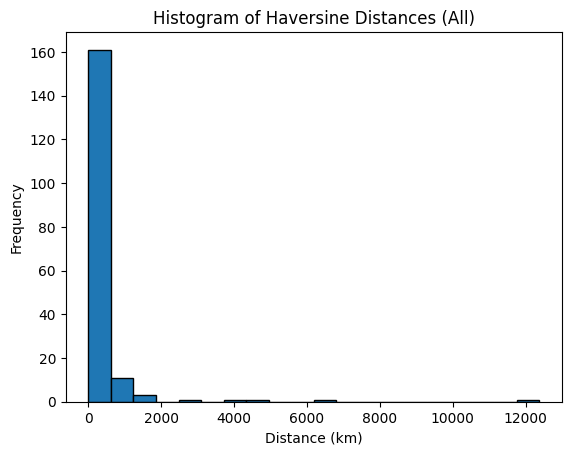

In [198]:
# Histogram of Haversine distances 
plt.hist(results_df["gt_gpt_coords_haversine_dist"], bins=20, edgecolor='black')
plt.title("Histogram of Haversine Distances (All)")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.show()

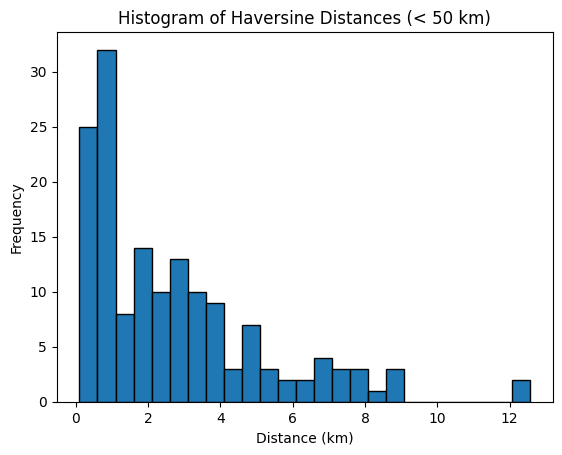

In [199]:
# Histogram of Haversine distances (< 50km)
filtered_df = results_df[results_df['gt_gpt_coords_haversine_dist'] < 50]
plt.hist(filtered_df["gt_gpt_coords_haversine_dist"], bins=25, edgecolor='black')
plt.title("Histogram of Haversine Distances (< 50 km)")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.show()